<a href="https://colab.research.google.com/github/MeghaPujamath/Reinforcement-Learning---DQN-for-cartpole-environment-/blob/main/Error_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import random
import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

batch_size = 32 #No of transitions that we sample from replay buffer while calculating gradients
n_episodes = 1001
discountFactor = 0.99
epsilon = 1.0
epsilonFactor = 10000
minEpsilon = 0.02
learning_rate = 0.001
buffer_size = 50000 #Max No of trqnsitions that we store before clearing out
min_replay_size = 1000 #No of transitions stored in replay buffer before we start computing gradients and training
target_update_fre = 1000 #no of steps that we update target paramters equal to online parameters
episode_length = 100


env = gym.make('CartPole-v0')
memory = deque(maxlen=buffer_size)
reward_buffer = deque()

state_size = env.observation_space.shape
action_size = env.action_space.n

class ModelNetwork(nn.Module):
  def __init__(self, env):
    super().__init__()
    input_features = int(np.prod(state_size))
    self.net = nn.Sequential(nn.Linear(input_features, 64), nn.Tanh(), nn.Linear(64, action_size))

  def forward(self, x):
    return self.net(x)

  def act(self, state):
    # with torch.no_grad():
    state_t = torch.as_tensor(state, dtype=torch.float32) #converting state to torch tensor
    q_values = main_net(state_t.unsqueeze(0)) #Creating fake batch dimensions of 1

    max_q_index = torch.argmax(q_values, dim=1)[0]
    action = max_q_index.detach().item() # converting torch tensor to integer
    return action

main_net = ModelNetwork(env) #Main network is actually trained
target_net = ModelNetwork(env) #target network is used to generate target values or ground truth

target_net.load_state_dict(main_net.state_dict())
optimizer = torch.optim.Adam(main_net.parameters(), learning_rate)


# class DQNAgent():
#   def __init__(self):
#     self.loss_fn = torch.nn.MSELoss()

#   def act(self, state):
#     # with torch.no_grad():
#     state_t = torch.as_tensor(state, dtype=torch.float32) #converting state to torch tensor
#     q_values = main_net(state_t.unsqueeze(0)) #Creating fake batch dimensions of 1

#     max_q_index = torch.argmax(q_values, dim=1)[0]
#     action = max_q_index.detach().item() # converting torch tensor to integer
#     return action
  
#   def trainNetwork(self, batch_size, minibatch):
#     states = np.asarray([m[0] for m in minibatch])
#     actions = np.asarray([m[1] for m in minibatch])
#     rewards = np.asarray([m[2] for m in minibatch])
#     next_states = np.asarray([m[3] for m in minibatch])
#     dones = np.asarray([m[4] for m in minibatch])

#     states_t = torch.as_tensor(states, dtype=torch.float32)
#     actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
#     rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
#     done_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
#     next_states_t = torch.as_tensor(next_states, dtype=torch.float32)

#     #Actual q values or ground truth from target network using next state
#     target_q_values = target_net(next_states_t) 
#     max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
#     targets = rewards_t + discountFactor*(1-done_t)*max_target_q_values
#     # test = torch.tensor(targets, requires_grad=True)

#     #Predicted q values from main network using current state
#     q_values = main_net(states_t)
#     # action_q_values, _ = torch.max(q_values, axis=1)
#     action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)
#     # test2 = torch.tensor(action_q_values, requires_grad=True)

#     #Compute Losses
#     # loss = nn.functional.smooth_l1_loss(action_q_values, targets)
#     loss = self.loss_fn(action_q_values, targets)

#     #Gradient Descent Step
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     return loss.item()


state = env.reset()
for _ in range(min_replay_size):
  action = env.action_space.sample()
  # ipdb.set_trace()
  # d = env.step(action)
  next_state, reward, done, _ = env.step(action)
  memory.append((state, action, reward, next_state, done))

  state = next_state
  if done:
    state = env.reset()

episode_reward = 0.0
losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
losses = 0
state = env.reset()
for i in range(2):
  for e in itertools.count():
    epsi = np.interp(e, [0, epsilonFactor], [epsilon, minEpsilon])
    if random.random() <= epsi:
      action = env.action_space.sample() #random action selection i.e exploring
    else:
      # ipdb.set_trace()
      action = main_net.act(state)

    next_state, reward, done, _ = env.step(action)
    memory.append((state, action, reward, next_state, done))

    state = next_state
    episode_reward += reward
    if done:
      state = env.reset()
      reward_buffer.append(episode_reward)
      episode_reward = 0.0


    minibatch = random.sample(memory, batch_size)

    states = np.asarray([m[0] for m in minibatch])
    actions = np.asarray([m[1] for m in minibatch])
    rewards = np.asarray([m[2] for m in minibatch])
    next_states = np.asarray([m[3] for m in minibatch])
    dones = np.asarray([m[4] for m in minibatch])


    states_t = torch.as_tensor(states, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
    done_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    next_states_t = torch.as_tensor(next_states, dtype=torch.float32)

    target_q_values = target_net(next_states_t) #set of qvalues for each state. Each state has vast dimension and q values are dimension 1
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

    targets = rewards_t + discountFactor*(1-done_t)*max_target_q_values

    #Compute Losses

    q_values = main_net(states_t)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

    loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    losses += loss.item()
    #Gradient Descent Step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if done:
    #   episode_durations.append(e + 1)
    #   plot_durations()
    #   break

    #Update the Target Network
    if e % target_update_fre== 0:
      target_net.load_state_dict(main_net.state_dict())
    
    # losses_list.append(losses/e)
    reward_list = reward_buffer
    episode_len_list.append(e)
    epsilon_list.append(epsi)


    if e%10 == 0:
      print()
      print('Step', e)
      print('Avg Reward', np.mean(reward_buffer))

      # durations_t = torch.tensor(reward_list, dtype=torch.float)
      # plt.title('Training...')
      # plt.xlabel('Episode')
      # plt.ylabel('Duration')
      # plt.xlim([50, 300])
      # plt.plot(durations_t.numpy())
      
      # plt.show()

    # plot_durations(reward_list)
    
  # durations_t = torch.tensor(reward_list, dtype=torch.float)
  # plt.title('Training...')
  # plt.xlabel('Episode')
  # plt.ylabel('Duration')
  # plt.xlim([50, 300])
  # plt.plot(durations_t.numpy())
  
  # plt.show()


# print('Complete')
# env.render()
# env.close()
# plt.ioff()
# plt.show()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu


Step 0
Avg Reward nan

Step 10
Avg Reward nan

Step 20
Avg Reward 12.0

Step 30
Avg Reward 12.0

Step 40
Avg Reward 16.0

Step 50
Avg Reward 16.0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
Step 463180
Avg Reward 166.99459069599712

Step 463190
Avg Reward 166.99459069599712

Step 463200
Avg Reward 166.99459069599712

Step 463210
Avg Reward 166.99459069599712

Step 463220
Avg Reward 166.99459069599712

Step 463230
Avg Reward 166.99459069599712

Step 463240
Avg Reward 166.99459069599712

Step 463250
Avg Reward 166.99459069599712

Step 463260
Avg Reward 166.99459069599712

Step 463270
Avg Reward 166.99459069599712

Step 463280
Avg Reward 167.00648882480172

Step 463290
Avg Reward 167.00648882480172

Step 463300
Avg Reward 167.00648882480172

Step 463310
Avg Reward 167.00648882480172

Step 463320
Avg Reward 167.00648882480172

Step 463330
Avg Reward 167.00648882480172

Step 463340
Avg Reward 167.00648882480172

Step 463350
Avg Reward 167.00648882480172

Step 463360
Avg Reward 167.00648882480172

Step 463370
Avg Reward 167.00648882480172

Step 463380
Avg Reward 167.00648882480172

Step 463390
Avg Reward 167.00648882480172

Ste

KeyboardInterrupt: ignored

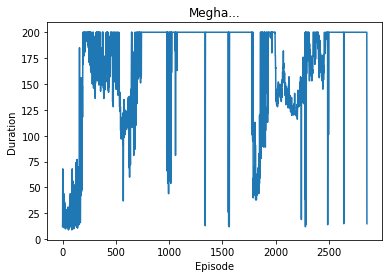

In [2]:
plt.figure(2)
plt.clf()
durations_t = torch.tensor(reward_buffer, dtype=torch.float)
plt.title('Megha...')
plt.xlabel('Episode')
plt.ylabel('Duration')
k = range(10000)
plt.plot(reward_buffer)